In [2]:
from keras.models import Sequential, load_model
import pandas as pd
import numpy as np
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import random
import datetime

from Indicator import Indicator

In [3]:
def fillindicator(df):
    indicator = Indicator()
    train_set = indicator.MACD(df,12,26,9,1)#MACD 1
    train_set = indicator.MACD(df,40,60,34,2)#MACD 2
    train_set = indicator.DMI(df,14)
    train_set = indicator.STOCHRSI(df)
    train_set = indicator.AO(df)
    train_set = indicator.WILLIANSR(df)
    train_set = indicator.RSI(df)
    train_set = indicator.MA(df,26)
    train_set['MA-26'] = train_set['MA']
    train_set = indicator.MA(df,15)
    train_set = indicator.check_trend(df)
    return train_set

def shiftdata(df,col_name,sft):
    for i in range(sft):
        i+=1
        shiftname = col_name+'-'+str(i)
        df[shiftname] = df[col_name].shift(i)

    return df

def norm(df,col_name):# this will get columnname + _n
    #Normalize data each colunm in to range -1 to 1
    df[col_name+'_n'] = 2*(df[col_name]-df[col_name].min())/(df[col_name].max()-df[col_name].min())-1    
    return df

def signal_to_catagorical(data):
    data.loc[data['Signal'] == 'wait ot hold', 'Signal'] = 'wait or hold'
    data.loc[data['Signal'] == 'buy', 'Signal'] = 0
    data.loc[data['Signal'] == 'sell', 'Signal'] = 1 
    data.loc[data['Signal'] == 'wait or hold', 'Signal'] = 2 
    return data

def add_shift_day(data,day):
    r_list = []
    for i in range(day,len(data)):#Number mean day to shift
        r_list.append(data[i-day : i])
    return np.array(r_list)

In [4]:
start = datetime.datetime(2019,1,1)#26 day before start year for make indicator
end = datetime.datetime(2021,1,1)
stock = 'EBAY'
df = web.DataReader(stock,'yahoo',start,end)
df = fillindicator(df)
df['AO-signal'] = np.where(df['AO'] > df['AO'].shift(1),1,0)
df.loc[df['Trend'] == 'Down', 'Trend'] = 0.1
df.loc[df['Trend'] == 'Up', 'Trend'] = 0.9 

#Delta
df['MACD-SL-1'] = df['MACD-1'] - df['SIGNAL LINE1']
df['MACD-SL-2'] = df['MACD-2'] - df['SIGNAL LINE2']
df['DMI'] = df['plusDI'] - df['minusDI']
df['STOCHRSI'] = df['%K'] - df['%D']
df['MA-trend'] = df['MA-26'] - df['Close']

#MACD
df = norm(df,'MACD-SL-1')
df = norm(df,'MACD-SL-2')
df = norm(df,'MACD-1')
df = norm(df,'MACD-2')
df = norm(df,'SIGNAL LINE1')
df = norm(df,'SIGNAL LINE2')

#DMI
df = norm(df,'plusDI')
df = norm(df,'minusDI')
df = norm(df,'DMI')

#StochasticRSI
df = norm(df,'%K')
df = norm(df,'%D')
df = norm(df,'STOCHRSI')

#Other
df = norm(df,'Close')
df = norm(df,'%R')
df = norm(df,'RSI')
df = norm(df,'AO')
df = norm(df,'MA-trend')

df = df[63:]

C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\jame_\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [5]:
model = load_model('Model/model_lstm3_1_20.h5')
# model = load_model('Model/model_lstm_data20_2.h5')

C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jame_\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

Text(0.5, 0, 'Date')

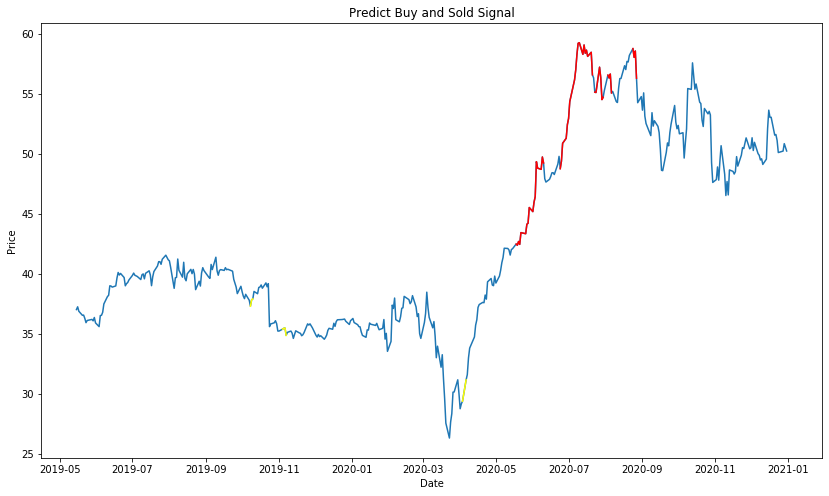

In [6]:
p_test = df
# p_test = signal_to_catagorical(p_test)
x_test = p_test[['MACD-SL-1_n','DMI_n','MACD-SL-2_n','Close_n','AO_n','RSI_n','MA-trend']].values
x_test = add_shift_day(x_test,30)
# y_test = p_test['Signal'].values
# y_test = y_test.tolist()
# del y_test[0:30]
# y_test = np.array(y_test)
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = -1)
p_test = p_test.iloc[30:]

p_test['pred'] = y_pred
p_test['pred_b'] = np.where(p_test['pred'] == 0,p_test['Close'],np.nan)
p_test['pred_s'] = np.where(p_test['pred'] == 1,p_test['Close'],np.nan)

plt.figure(figsize=(14,8))
# plt.grid()
plt.title('Predict Buy and Sold Signal')
plt.plot(p_test['Close'])
plt.plot(p_test['pred_b'],color='yellow')
plt.plot(p_test['pred_s'],color='red')
plt.ylabel('Price')
plt.xlabel('Date')

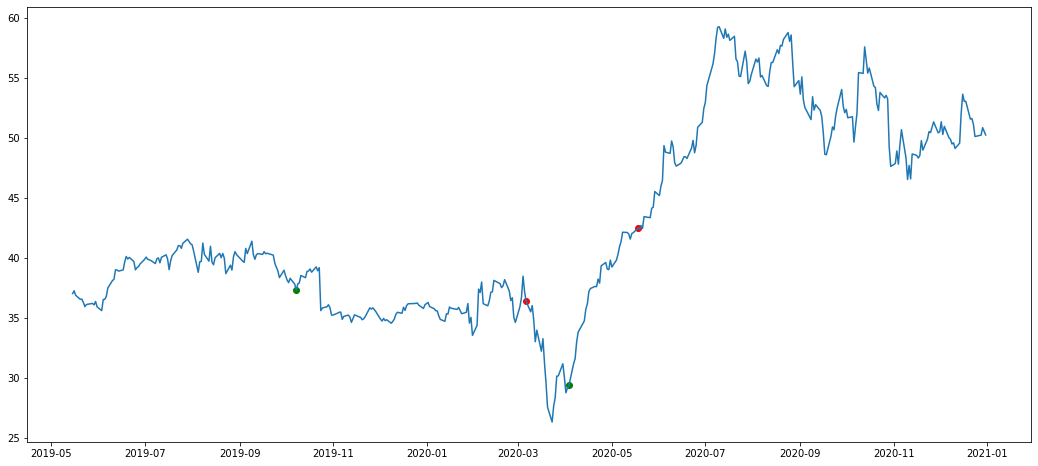

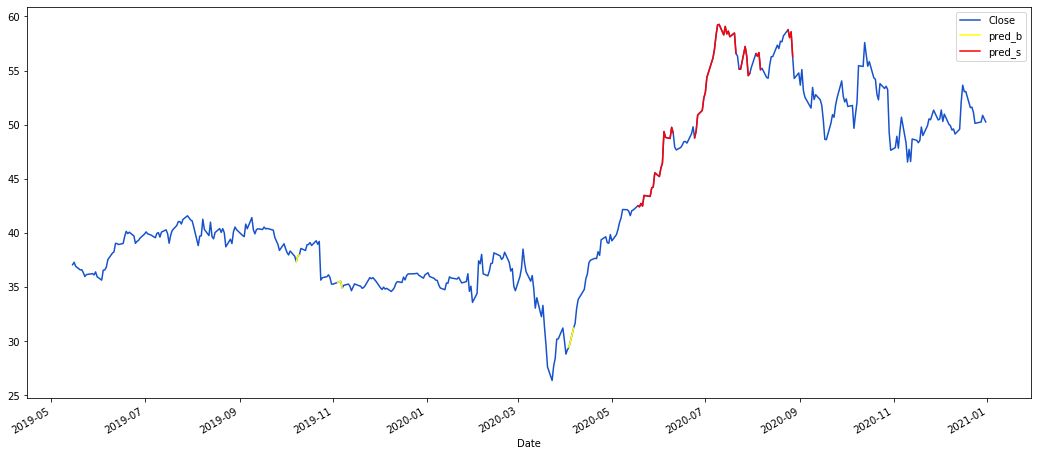

In [34]:
plt.figure(figsize=(18,8))
plt.plot(p_test.index,p_test['Close'])
b = []
s = []
flag = 'sell'
for i,r in p_test.iterrows():
    if (flag=='sell') & (r['pred']==0):
        plt.scatter(x=i, y=r['Close'], c='green')
        b.append(r['Close'])
        flag = 'buy'
    elif (flag=='buy') & (r['pred']==1):
        plt.scatter(x=i, y=r['Close'], c='red')
        s.append(r['Close'])
        flag = 'sell'
plt.savefig('EX1.png',dpi=600)
p_test[['Close','pred_b','pred_s']].plot(figsize=(18,8),color=['#1652cb','yellow','red'])
plt.savefig('EX2.png',dpi=600)
plt.show()

<Figure size 432x288 with 0 Axes>